In [1]:
#Imports
import logging
import os, random, time, sys
import numpy as np
import tensorflow as tf
import tensorflow.contrib.layers as layers
sys.path.append('../')
sys.path.append('../util/')
import feedforward_robust as ffr
import ipdb
from util import *

#Read the counter
ctr_file = "counter.txt"
f = open(ctr_file, 'r')
counter = f.readline()
f.close()

counter = 1 + int(counter)
f = open(ctr_file,'w')
f.write('{}'.format(counter))
f.close()
logfile = "logs/results_" + str(counter) + ".log"

logger = logging.getLogger("robustness")
logger.setLevel(logging.DEBUG)
fh = logging.FileHandler(logfile)
fh.setLevel(logging.INFO)
formatter = logging.Formatter('%(asctime)s - %(name)s - %(levelname)s - %(message)s')
fh.setFormatter(formatter)
logger.addHandler(fh)
logger.addHandler(logging.StreamHandler())

In [2]:
#Setup - Dataset stuff
dataset, input_shape, num_classes = get_dataset()
x_train_flat, y_train = dataset[0] 
x_test_flat, y_test = dataset[1] 
hidden_sizes = [32,32,32,32,32,32,32]

In [3]:
x_train_flat.shape

(60000, 784)

In [4]:
def plot_singular_values(matrix, idx):
    _, sig, V = np.linalg.svd(matrix)
    plt.plot(range(len(sig)), sig, label = "Layer number %d" %idx)
    plt.legend(loc = 'upper right')
    return sig

## Regular Training

In [5]:
#Config
eps_train = 0.1
eps_test = 0.1
tensorboard_dir = "tb/"
weights_dir = "weights/"

load_counter = 58
sigma = tf.nn.relu

scope_name = "model_non_robust"

In [6]:
with tf.variable_scope(scope_name) as scope:
    sess = tf.Session()
    logdir = tensorboard_dir + str(counter) + "/non_robust"

    #Create, train and test model
    writer = tf.summary.FileWriter(logdir)
    model = ffr.RobustMLP(input_shape, hidden_sizes, num_classes, writer = writer, scope = scope_name, logger = logger, sigma =sigma)
    logger.info("Created model successfully. Now going to load weights")

    #Restore weights
    weights = tf.trainable_variables()
    saver = tf.train.Saver(weights)
    weights_path = saver.restore(sess, weights_dir + "model_" + str(load_counter) + ".ckpt")

    writer.add_graph(sess.graph)

    loss_reg, acc_reg = model.evaluate(sess, x_test_flat, y_test)
    logger.info("----Regular test accuracy and loss ----")
    logger.info((loss_reg, acc_reg))

    
    with tf.variable_scope("testing_benign") as scope:
        loss_reg, acc_reg = model.evaluate(sess, x_test_flat, y_test)
        logger.info("----Regular test accuracy and loss ----")
        logger.info((loss_reg, acc_reg))


    with tf.variable_scope("testing_adversarial") as scope:
        loss_fgsm, acc_fgsm = model.adv_evaluate(sess, x_test_flat, y_test, eps_test, pgd = False)
        logger.info("----FGSM test accuracy and loss ----")
        logger.info((loss_fgsm, acc_fgsm))
        x_test_flat_adv = model.fgsm_np(sess, x_test_flat, y_test, eps_test)


    #Distances and norms

    if False:
        norms = get_norms(model.get_weights()[0])
        norms_np = sess.run(norms)
        logger.info(norms_np)
        overall, overall_std, correct, _, incorrect, _ = model.get_distance(sess, eps_test, x_test_flat, y_test)
        logger.info("---Distances----")
        logger.info(overall)
        logger.info("------Std devs on Distances----")
        logger.info(overall_std)


    if False:
        #TSNE visualization of final layer.
        x_test_flat_adv = model.fgsm_np(sess, x_test_flat, y_test, eps_test)
        metadata_path = os.path.join(logdir, 'metadata.tsv')
        write_metadata(metadata_path, y_test_ogi[0:1000])
        sprite_path = os.path.join(logdir, 'sprite_images.png')
        write_sprite_image(sprite_path, x_test_ogi[0:1000])
        model.visualize_activation_tsne(sess, x_test_flat_adv[0:1000], 'metadata.tsv', 'sprite_images.png', logdir)


Initialized instance variables of the robust model class
I0813 11:35:42.248381 4588717504 feedforward_robust.py:30] Initialized instance variables of the robust model class
W0813 11:35:42.251872 4588717504 deprecation_wrapper.py:119] From ../feedforward_robust.py:34: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

Created placeholders for x and y
I0813 11:35:42.256817 4588717504 feedforward_robust.py:36] Created placeholders for x and y
W0813 11:35:42.259236 4588717504 deprecation_wrapper.py:119] From ../util/util.py:32: The name tf.variable_scope is deprecated. Please use tf.compat.v1.variable_scope instead.

W0813 11:35:42.260097 4588717504 deprecation_wrapper.py:119] From ../util/util.py:32: The name tf.AUTO_REUSE is deprecated. Please use tf.compat.v1.AUTO_REUSE instead.

W0813 11:35:42.263728 4588717504 deprecation_wrapper.py:119] From ../util/util.py:34: The name tf.get_variable is deprecated. Please use tf.compat.v1.get_variable instead.

W08

In [7]:
with tf.variable_scope(scope_name) as scope:
    weights = model.get_weights_np(sess)

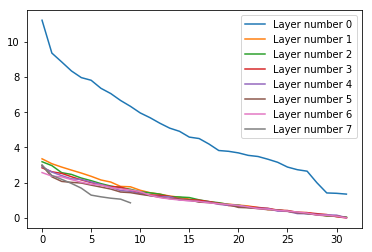

In [8]:
sing_vals = []
for (idx, weight_matrix) in enumerate(weights):
        sig = plot_singular_values(weight_matrix, idx)
        sing_vals.append(sig)

In [9]:
sing_vals

[array([11.219591 ,  9.356054 ,  8.853931 ,  8.339419 ,  7.9637704,
         7.8134637,  7.3564215,  7.058405 ,  6.66576  ,  6.3353806,
         5.959866 ,  5.688879 ,  5.37518  ,  5.0967546,  4.916018 ,
         4.587053 ,  4.5058117,  4.1946373,  3.826147 ,  3.7809627,
         3.6920755,  3.5512054,  3.4865568,  3.3326955,  3.158114 ,
         2.8874547,  2.7380967,  2.6529348,  1.9937172,  1.4182587,
         1.3975704,  1.3518547], dtype=float32),
 array([3.3555133 , 3.0770993 , 2.8867211 , 2.7135534 , 2.546874  ,
        2.3628848 , 2.154325  , 2.0367765 , 1.7889944 , 1.7673813 ,
        1.5701079 , 1.4319557 , 1.3497653 , 1.2428688 , 1.1750933 ,
        1.0686702 , 0.9814576 , 0.8870417 , 0.8434903 , 0.7797669 ,
        0.7305877 , 0.6794515 , 0.58738804, 0.4739951 , 0.4635789 ,
        0.3811394 , 0.31063223, 0.3000163 , 0.18293275, 0.12966576,
        0.1047547 , 0.02554336], dtype=float32),
 array([3.190353  , 2.9698312 , 2.5693169 , 2.4689467 , 2.2635596 ,
        2.1147387 

# Adversarial Training

In [10]:
#Config
eps_train = 0.1
eps_test = 0.1
tensorboard_dir = "tb/"
weights_dir = "weights/"

load_counter = 75
sigma = tf.nn.relu

scope_name_rob = "model_robust"

In [11]:
sess = tf.Session()
hidden_sizes = [32,32,32,32,32,32,32]
dataset = ((x_train_flat, y_train), (x_test_flat, y_test))

with tf.variable_scope(scope_name_rob) as scope:
    logdir = tensorboard_dir + str(counter) + "/robust"
    writer_robust = tf.summary.FileWriter(logdir)
    logger.info("Adversarial Training")
    robust_model = ffr.RobustMLP(input_shape, hidden_sizes, num_classes, writer = writer_robust, scope = scope_name_rob, logger = logger, sigma = sigma)
    sess.run(tf.global_variables_initializer())
    robust_model.adv_fit(sess, x_train_flat, y_train, eps_train, lr = 3e-4, training_epochs = 20)


    loss_reg, acc_reg = robust_model.evaluate(sess, x_test_flat, y_test)
    loss_adv, acc_adv = robust_model.adv_evaluate(sess, x_test_flat, y_test, eps_test)

Adversarial Training
I0813 11:35:43.545417 4588717504 <ipython-input-11-88acce1c6774>:8] Adversarial Training
Initialized instance variables of the robust model class
I0813 11:35:43.547413 4588717504 feedforward_robust.py:30] Initialized instance variables of the robust model class
Created placeholders for x and y
I0813 11:35:43.552323 4588717504 feedforward_robust.py:36] Created placeholders for x and y
Created layers and tensor for logits
I0813 11:35:43.676810 4588717504 feedforward_robust.py:40] Created layers and tensor for logits
Added loss computation to the graph
I0813 11:35:43.700098 4588717504 feedforward_robust.py:45] Added loss computation to the graph
Added accuracy computation to the graph
I0813 11:35:43.708029 4588717504 feedforward_robust.py:49] Added accuracy computation to the graph
Model graph was created
I0813 11:35:43.710850 4588717504 feedforward_robust.py:52] Model graph was created
W0813 11:35:43.908967 4588717504 deprecation.py:323] From ../feedforward_robust.py

In [12]:
loss_reg, acc_reg

(0.25647563, 0.9283)

In [13]:
loss_adv, acc_adv

(0.53582734, 0.8272)

In [14]:
with tf.variable_scope(scope_name) as scope:
    weights_robust = robust_model.get_weights_np(sess)

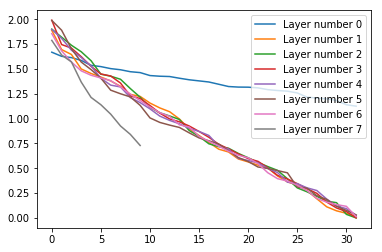

In [15]:
sing_vals_robust = []
for (idx, weight_matrix) in enumerate(weights_robust):
    sig = plot_singular_values(weight_matrix, idx)
    sing_vals_robust.append(sig)

In [16]:
sing_vals[0]

array([11.219591 ,  9.356054 ,  8.853931 ,  8.339419 ,  7.9637704,
        7.8134637,  7.3564215,  7.058405 ,  6.66576  ,  6.3353806,
        5.959866 ,  5.688879 ,  5.37518  ,  5.0967546,  4.916018 ,
        4.587053 ,  4.5058117,  4.1946373,  3.826147 ,  3.7809627,
        3.6920755,  3.5512054,  3.4865568,  3.3326955,  3.158114 ,
        2.8874547,  2.7380967,  2.6529348,  1.9937172,  1.4182587,
        1.3975704,  1.3518547], dtype=float32)

In [17]:
sing_vals_robust[0]

array([1.6677608, 1.626581 , 1.6134169, 1.5850725, 1.5359833, 1.52294  ,
       1.5027137, 1.491237 , 1.4716235, 1.462723 , 1.4329294, 1.426279 ,
       1.4231696, 1.4060042, 1.390371 , 1.3793149, 1.3681217, 1.3454535,
       1.3225484, 1.316983 , 1.3159894, 1.3092301, 1.2912441, 1.2824394,
       1.2758757, 1.2579869, 1.2159212, 1.2065603, 1.198459 , 1.1821938,
       1.1394651, 1.1249021], dtype=float32)

In [18]:
sing_vals[1]

array([3.3555133 , 3.0770993 , 2.8867211 , 2.7135534 , 2.546874  ,
       2.3628848 , 2.154325  , 2.0367765 , 1.7889944 , 1.7673813 ,
       1.5701079 , 1.4319557 , 1.3497653 , 1.2428688 , 1.1750933 ,
       1.0686702 , 0.9814576 , 0.8870417 , 0.8434903 , 0.7797669 ,
       0.7305877 , 0.6794515 , 0.58738804, 0.4739951 , 0.4635789 ,
       0.3811394 , 0.31063223, 0.3000163 , 0.18293275, 0.12966576,
       0.1047547 , 0.02554336], dtype=float32)

In [19]:
sing_vals_robust[1]

array([1.887668  , 1.6942089 , 1.6449747 , 1.499068  , 1.4538122 ,
       1.4178838 , 1.3789313 , 1.3248868 , 1.2434738 , 1.223006  ,
       1.1563638 , 1.1074302 , 1.0692275 , 0.99580574, 0.896246  ,
       0.8298066 , 0.76028234, 0.6924086 , 0.6641896 , 0.593825  ,
       0.5642524 , 0.5320855 , 0.5032892 , 0.42221197, 0.36385456,
       0.3311913 , 0.27531707, 0.19318244, 0.11271328, 0.07225836,
       0.04739637, 0.01530137], dtype=float32)

In [20]:
sing_vals[2]

array([3.190353  , 2.9698312 , 2.5693169 , 2.4689467 , 2.2635596 ,
       2.1147387 , 1.9464352 , 1.807925  , 1.7158626 , 1.6282052 ,
       1.4895344 , 1.4230894 , 1.3509948 , 1.2100762 , 1.1883975 ,
       1.1575755 , 1.0261064 , 0.9290708 , 0.86253023, 0.76148295,
       0.72430235, 0.61824846, 0.55077726, 0.5103169 , 0.43055552,
       0.38944536, 0.3188387 , 0.23886074, 0.20708954, 0.12144791,
       0.08276477, 0.04309303], dtype=float32)

In [21]:
sing_vals_robust[2]

array([1.9001371e+00, 1.8189362e+00, 1.7378025e+00, 1.6721936e+00,
       1.5821770e+00, 1.4467629e+00, 1.4266459e+00, 1.3954374e+00,
       1.3020606e+00, 1.2151195e+00, 1.1128029e+00, 1.0583509e+00,
       1.0264461e+00, 9.9107736e-01, 8.7979048e-01, 8.2068938e-01,
       7.4639565e-01, 7.1775836e-01, 7.0205998e-01, 6.4946991e-01,
       6.0596347e-01, 5.5866909e-01, 5.1745045e-01, 4.7880158e-01,
       3.9480546e-01, 3.0306813e-01, 2.6341805e-01, 2.1788399e-01,
       1.6934510e-01, 1.5416868e-01, 3.6822736e-02, 8.2874682e-04],
      dtype=float32)

In [22]:
sing_vals[-1]

array([3.005259 , 2.409253 , 2.191596 , 1.9573574, 1.6897454, 1.2956517,
       1.1981667, 1.1196339, 1.0656364, 0.8578519], dtype=float32)

In [23]:
sing_vals_robust[-1]

array([1.7867657 , 1.6395731 , 1.5704894 , 1.3672873 , 1.2130424 ,
       1.1392665 , 1.0446727 , 0.92542356, 0.84131914, 0.7295372 ],
      dtype=float32)